In [1]:
import os 
import sys

import warnings
warnings.filterwarnings('ignore')

import geopandas as gpd
from geopandas.tools import overlay
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup
else:
    import aup
    
import random

## Guadalajara hexagon grid

In [2]:
type = "urban"
city = "Guadalajara"
query_urban = f"SELECT * FROM hexgrid.hexgrid_8_city_2020 WHERE \"city\" LIKE \'{city}\' AND \"type\" LIKE \'{type}\'"
query_urban

'SELECT * FROM hexgrid.hexgrid_8_city_2020 WHERE "city" LIKE \'Guadalajara\' AND "type" LIKE \'urban\''

In [3]:
hex_gdf = aup.gdf_from_query(query_urban, geometry_col='geometry')
print(hex_gdf.shape)
hex_gdf.head(2)

(1132, 6)


,hex_id_8,geometry,CVEGEO,NOMGEO,city,type
0,88498c9421fffff,"POLYGON ((-103.28663 20.69309, -103.28209 20.6...",14039,Guadalajara,Guadalajara,urban
1,88498c9405fffff,"POLYGON ((-103.30025 20.68392, -103.29571 20.6...",14039,Guadalajara,Guadalajara,urban


## Edges and nodes

In [4]:
G, nodes, edges = aup.graph_from_hippo(hex_gdf, schema='osmnx', 
                                       edges_folder='edges_elevation_23_line', 
                                       nodes_folder='nodes_osmnx_23_point') 

In [5]:
nodes = nodes.reset_index()
nodes.head(2)

,osmid,x,y,street_count,geometry,city
0,1363860294,-103.382580,20.629876,3,POINT (-103.38258 20.62988),Guadalajara
1,28791285,-103.386947,20.674579,3,POINT (-103.38695 20.67458),Guadalajara


In [6]:
edges = edges.reset_index()
edges.head(2)

,u,v,key,osmid,oneway,name,highway,length,geometry,grade,grade_abs,lanes,bridge,maxspeed,ref,access,junction,service,tunnel,width
0,1774344156,1827050267,0,782694623,False,Calle Santa Rosa,residential,70.113,"LINESTRING (-103.32081 20.56605, -103.32112 20...",-0.014,0.014,None,None,None,None,None,None,None,None,None
1,1774344156,6511605645,0,"[473698618, 693569732]",False,"['Privada San Diego', 'Calle Puerto Escondido']",residential,199.626,"LINESTRING (-103.32081 20.56605, -103.32191 20...",-0.005,0.005,None,None,None,None,None,None,None,None,None


In [7]:
edges_var = edges.copy()
edges_var = edges_var.reset_index()
edges_var = edges_var.to_crs("EPSG:32613")
edges_var = edges_var[['u','v','key','osmid','grade_abs','geometry']] # Ya contiene a las prendientes.

## NDVI

In [8]:
hex_schema = "raster_analysis"
# hex_schema_pob = "hexgrid" <- esta variable no se usa
hex_table = "ndvi_analysis_hex"
# ndvi = "ndvi" <- esta variable no se usa
# hex_id = "hex_id" <- esta variable no se usa
city = 'Guadalajara' 
res = 11

# utilizar f strings para aprovechar las variables que definiste
query = f"SELECT * FROM {hex_schema}.{hex_table} WHERE city IN (\'{city}\') AND res = {res}";

ndvi_hex = aup.gdf_from_query(query, geometry_col='geometry') # usa nombre de variables más descriptivos de lo que contienen
ndvi_hex.head(3)

,hex_id,geometry,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,ndvi_2018,ndvi_2019,ndvi_2020,ndvi_2021,ndvi_2022,ndvi_2023,city
0,8b498c960081fff,"POLYGON ((-103.33538 20.63189, -103.33521 20.6...",11,0.108520,0.031560,0.114570,0.126383,0.086594,0.039789,-0.001356,0.145045,0.136144,0.120932,0.105613,0.069924,0.073464,Guadalajara
1,8b498c969b86fff,"POLYGON ((-103.40467 20.69205, -103.4045 20.69...",11,0.357138,0.095029,0.362383,0.443064,0.273010,0.170054,-0.003096,0.428775,0.411389,0.412872,0.390896,0.261162,0.237731,Guadalajara
2,8b498c96bc86fff,"POLYGON ((-103.36586 20.69916, -103.36569 20.6...",11,0.294156,0.055251,0.309146,0.347940,0.254543,0.093398,-0.001225,0.301426,0.321703,0.334762,0.347508,0.234717,0.224818,Guadalajara


In [9]:
edges.columns

Index(['u', 'v', 'key', 'osmid', 'oneway', 'name', 'highway', 'length',
       'geometry', 'grade', 'grade_abs', 'lanes', 'bridge', 'maxspeed', 'ref',
       'access', 'junction', 'service', 'tunnel', 'width'],
      dtype='object')

In [10]:
edges = edges[["u", "v", "key", "geometry", "osmid"]].copy()
print(edges.shape)
edges.head(2)

(414592, 5)


,u,v,key,geometry,osmid
0,1774344156,1827050267,0,"LINESTRING (-103.32081 20.56605, -103.32112 20...",782694623
1,1774344156,6511605645,0,"LINESTRING (-103.32081 20.56605, -103.32191 20...","[473698618, 693569732]"


In [11]:
# Hacer la unión espacial para asignar valores NDVI a edges
edges_ndvi = gpd.overlay(edges, ndvi_hex, how='intersection')
print(edges_ndvi.shape)
edges_ndvi.head(2)

(1093004, 21)


,u,v,key,osmid,hex_id,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,...,ndvi_diff,ndvi_tend,ndvi_2018,ndvi_2019,ndvi_2020,ndvi_2021,ndvi_2022,ndvi_2023,city,geometry
0,1774344156,1827050267,0,782694623,8b49aa2dd112fff,11,0.237589,0.060735,0.245390,0.302490,...,0.114107,-0.001774,0.287252,0.259241,0.268560,0.269781,0.172742,0.167955,Guadalajara,"LINESTRING (-103.32081 20.56605, -103.321 20.5..."
1,1774344156,1827050267,0,782694623,8b49aa2dd116fff,11,0.143443,0.043435,0.144357,0.191011,...,0.087279,-0.001412,0.180311,0.168778,0.161322,0.154583,0.102798,0.092862,Guadalajara,"LINESTRING (-103.32102 20.56568, -103.32112 20..."


In [12]:
# Calcular la media del NDVI por cada calle (usando 'u', 'v', 'key' como identificadores)
ndvi_per_edge = edges_ndvi.groupby(['u', 'v', 'key'])['ndvi_mean'].mean().reset_index()

# Unir los datos de NDVI agregados con el dataset original de edges
edges_var = edges_var.merge(ndvi_per_edge, on=['u', 'v', 'key'], how='left')

# Rellenar valores nulos con 0 
edges_var['ndvi_mean'] = edges_var['ndvi_mean'].fillna(0)

In [13]:
edges_var.isna().sum()

u            0
v            0
key          0
osmid        0
grade_abs    0
geometry     0
ndvi_mean    0
dtype: int64

<Axes: >

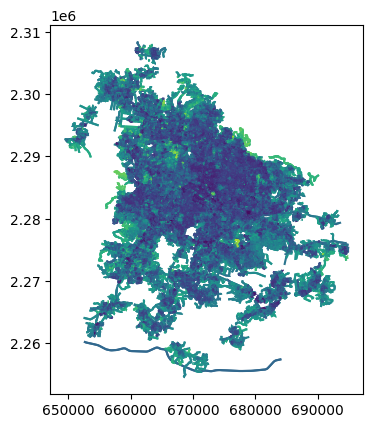

In [14]:
edges_var.plot("ndvi_mean")

Se comentaron todas las variables que no se utilizan

In [15]:
# edges.drop(columns="geometry").to_json("edges_ndvi.json", orient="records", lines=True)

In [16]:
# edges.to_file("edges_with_ndvi.shp")

In [17]:
# edges.to_file("edges_with_ndvi.geojson", driver="GeoJSON")

## Uso de suelo

In [18]:
edges_buffer = edges_var.copy()
edges_buffer['geometry'] = edges_buffer.buffer(50)

In [19]:
# Cargar datos
land_use = gpd.read_file("../../../data/processed/vref/predios_uso_suelo.geojson")
print(land_use.shape)
land_use.head(2)

(677371, 2)


,clasificacion_uso_suelo,geometry
0,Residencial,"POLYGON ((668816.105 2295371.324, 668811.832 2..."
1,Residencial,"POLYGON ((668729.69 2295298.382, 668723.108 22..."


In [20]:
# Convertir a coordenadas proyectadas para cálculos espaciales
land_use = land_use.to_crs('epsg:32613')
edges_buffer = edges_buffer.to_crs('epsg:32613')

# Filtrar solo los polígonos de uso de suelo Residencial
# land_use_residencial = land_use[land_use['clasificacion_uso_suelo'].isin(['Residencial', 'Mixto'])]

# Calcular intersecciones solo con uso de suelo Residencial
edges_uso_suelo = gpd.overlay(edges_buffer, land_use, 
                              how='intersection')

# Mostrar las primeras filas
print(edges_uso_suelo.shape)
edges_uso_suelo.head()


(7838291, 8)


,u,v,key,osmid,grade_abs,ndvi_mean,clasificacion_uso_suelo,geometry
0,9342184105,1793387649,0,167542247,0.0,0.154674,Residencial,"POLYGON ((664144.036 2281979.588, 664142.555 2..."
1,9342184105,1793387649,0,167542247,0.0,0.154674,Residencial,"POLYGON ((664139 2281987.564, 664142.85 228198..."
2,9342184105,1793387649,0,167542247,0.0,0.154674,Residencial,"POLYGON ((664025.856 2281970.924, 664025.434 2..."
3,9342184105,1793387649,0,167542247,0.0,0.154674,Residencial,"POLYGON ((664145.052 2281984.389, 664144.31 22..."
4,9342184105,1793387649,0,167542247,0.0,0.154674,Residencial,"POLYGON ((664145.651 2281994.172, 664145.592 2..."


In [21]:

# Calcular el área de intersección
edges_uso_suelo['area_inte'] = edges_uso_suelo.geometry.area

# Sumar el área de intersección por cada segmento de calle
area_usos_edges = edges_uso_suelo.groupby(['u', 'v', 'key'])['area_inte'].sum()

# Calcular la proporción de cada uso de suelo
land_use_presence_edges = edges_uso_suelo.groupby(['u', 'v', 'key', 'clasificacion_uso_suelo'])['area_inte'].sum()
percentage_land_use_edges = land_use_presence_edges / area_usos_edges

print("Número de intersecciones:", len(edges_uso_suelo))
print("Número de calles únicas con intersecciones:", edges_uso_suelo[['u', 'v', 'key']].nunique())

# Calcular el número de categorías por calle
n_land_use = edges_uso_suelo.groupby(['u', 'v', 'key'])['clasificacion_uso_suelo'].unique().apply(len)

# Aplicar la fórmula de entropía de Shannon
def calcular_entropia(osmid, percentage_series):
    if osmid not in percentage_series.index or len(percentage_series.loc[osmid]) == 1:
        return 0  # Sin datos o solo un uso → entropía 0

    probs = percentage_series.loc[osmid].values
    return -np.sum(probs * np.log2(probs))

edges_buffer['entropy'] = edges_buffer.set_index(['u', 'v', 'key']).index.map(
    lambda idx: calcular_entropia(idx, percentage_land_use_edges))

# Convertir a CRS original y guardar resultado
# edges_buffer['buffer_wkt'] = edges_buffer['geometry'].apply(lambda geom: geom.wkt)   # no me queda del todo claro qué se está haciendo aquí

Número de intersecciones: 7838291
Número de calles únicas con intersecciones: u      92868
v      92866
key        3
dtype: int64


### Data to edges

In [22]:
# Unir los datos de entropía al dataset de edges
edges_var = edges_var.merge(edges_buffer[['u','v','key','entropy']],
                            on=['u', 'v', 'key'], how='left')

# Rellenar valores nulos con 0 
edges_var['entropy'] = edges_var['entropy'].fillna(0)

<Axes: >

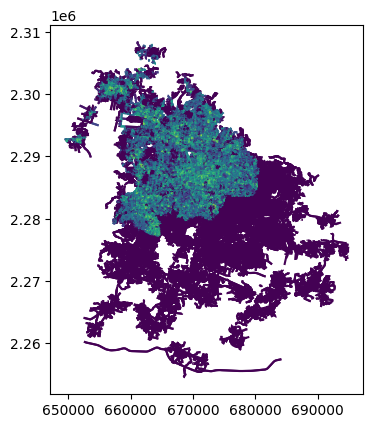

In [23]:
edges_var.plot('entropy')

## Sidewalks

In [24]:
gdf_tmp = hex_gdf.copy()
gdf_tmp = gdf_tmp.to_crs("EPSG:6372")
gdf_tmp = gdf_tmp.buffer(1).reset_index().rename(columns={0:'geometry'})
gdf_tmp = gdf_tmp.set_geometry("geometry")
gdf_tmp = gdf_tmp.to_crs("EPSG:4326")
poly_wkt = gdf_tmp.dissolve().geometry.to_wkt()[0]

In [25]:
query = f"SELECT * FROM censo_urbano.censo_fm_2020 WHERE ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\')"
gdf_sidewalk = aup.gdf_from_query(query, geometry_col='geometry')
print(gdf_sidewalk.shape)
gdf_sidewalk.head(4)

(261012, 68)


,CVEGEO2,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,CVEVIAL_x,CVESEG,CVEFT_x,NOMVIAL_x,...,ESTACIONBICI,ARBOLES,ALUMPUB,TELPUB,PUESTOSEMI,PUESTOAMBU,BANQUETA,GUARNICION,TAMLOC,VIANOESP
0,1412000013185020,14,120,0001,3185,020,07967,00001,4,Ninguno,...,3,3,3,3,3,3,3,1,11,0
1,1412000013185020,14,120,0001,3185,020,07967,00001,6,Ninguno,...,3,3,1,3,3,3,3,1,11,0
2,1412000011850003,14,120,0001,1850,003,04876,00008,4,Trafalgar,...,3,1,1,3,3,3,1,1,11,0
3,1412000011850006,14,120,0001,1850,006,07991,00001,3,Pasamontes,...,3,1,3,3,3,3,1,1,11,0


In [31]:
edges_buffer = edges_var[['u','v','key','geometry']].copy()
edges_buffer['geometry'] = edges_buffer.buffer(50)

In [32]:
# Convertir a CRS proyectado (UTM)
gdf_sidewalk = gdf_sidewalk.to_crs('EPSG:32613')

In [33]:
gdf_sidewalk['BANQUETA'].unique()

array([3, 1, 8, 9])

In [34]:
edges_sidewalk = gdf_sidewalk.overlay(edges_buffer, 
                                      how='intersection')
print(edges_sidewalk.shape)
edges_sidewalk.head(2)

(5026080, 71)


,CVEGEO2,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,CVEVIAL_x,CVESEG,CVEFT_x,NOMVIAL_x,...,PUESTOSEMI,PUESTOAMBU,BANQUETA,GUARNICION,TAMLOC,VIANOESP,u,v,key,geometry
0,1412000013185020,14,120,0001,3185,020,07967,00001,4,Ninguno,...,3,3,3,1,11,0,1782199594,1926295436,0,"LINESTRING (666676.105 2294806.069, 666663.342..."
1,1412000013185020,14,120,0001,3185,020,07967,00001,4,Ninguno,...,3,3,3,1,11,0,1926295441,6456324450,0,"LINESTRING (666673.72 2294797.771, 666663.342 ..."


In [35]:
edges_sidewalk['length'] = edges_sidewalk.length

In [36]:
banqueta_edges = edges_sidewalk[['u','v','key','BANQUETA','length']].groupby(['u','v','key','BANQUETA']).sum()
banqueta_edges = banqueta_edges.reset_index()
print(banqueta_edges.shape)
banqueta_edges.head(2)

(690975, 5)


,u,v,key,BANQUETA,length
0,28751344,28757777,0,1,829.885639
1,28751344,28757777,0,3,109.758512


In [47]:
# edges_var = edges_var.drop(columns=['BANQUETA_1','BANQUETA_3'])

In [48]:
edges_var = edges_var.merge(banqueta_edges.loc[banqueta_edges.BANQUETA==1,['u','v','key','length']],
                            on=['u','v','key'], how='left')
edges_var = edges_var.rename(columns={'length':'BANQUETA_1'})
edges_var = edges_var.merge(banqueta_edges.loc[banqueta_edges.BANQUETA==3,['u','v','key','length']],
                            on=['u','v','key'], how='left')
edges_var = edges_var.rename(columns={'length':'BANQUETA_3'})
print(edges_var.shape)
edges_var.head(2)

(414592, 11)


,u,v,key,osmid,grade_abs,geometry,ndvi_mean,entropy,banqueta_pct,BANQUETA_1,BANQUETA_3
0,1774344156,1827050267,0,782694623,0.014,"LINESTRING (675034.767 2275024.049, 675002.812...",0.228736,0.0,0.124501,95.863779,674.121402
1,1774344156,6511605645,0,"[473698618, 693569732]",0.005,"LINESTRING (675034.767 2275024.049, 674919.897...",0.273851,0.0,0.288890,299.357980,736.875516


In [49]:
edges_var['banqueta_pct'] = edges_var['BANQUETA_1'] / (edges_var['BANQUETA_1'] + edges_var['BANQUETA_3'])

<Axes: >

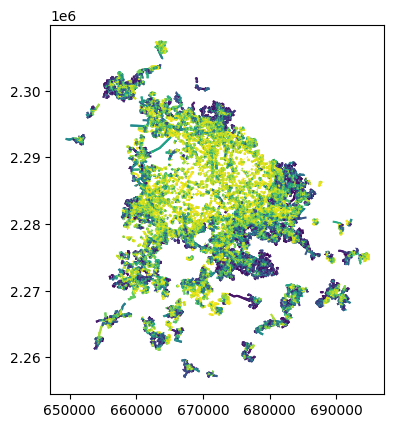

In [50]:
edges_var.plot('banqueta_pct')

In [51]:
edges_var.banqueta_pct = edges_var.banqueta_pct.fillna(1)

## Densidad a edges

In [52]:
nodes_id = edges_var.v.unique().tolist()
u = edges_var.u.unique().tolist()
nodes_id.extend(u)
myset = set(nodes_id)
nodes_id = list(myset)
schema = 'censo'
nodes_folder = 'pobcenso_inegi_20_mzaageb_node'
nodes_query = f"SELECT * FROM {schema}.{nodes_folder} WHERE osmid IN {str(tuple(nodes_id))}"
nodes_pop = aup.gdf_from_query(nodes_query, geometry_col="geometry", index_col="osmid")

In [53]:
voronoi = gpd.read_file('../../../data/processed/vref/Guadalajara_script22_voronoipolys_32613.gpkg')
voronoi = voronoi.to_crs("EPSG:32613")
voronoi['area_ha'] = voronoi.area/10000

In [54]:
# Realiza el merge para unir los datos de población y área desde `voronoi_gdf` a `nodes_gdf` basado en "osmid"
nodes_pop = nodes_pop.merge(
    voronoi[['osmid', 'area_ha']],  # Selecciona solo las columnas necesarias de voronoi_gdf
    on='osmid',
    how='left'
    )

# Verifica las primeras filas para asegurarte de que el merge se realizó correctamente
nodes_pop.head(3)

,osmid,geometry,pobtot,pobfem,pobmas,p_0a2,p_0a2_f,p_0a2_m,p_3a5,p_3a5_f,...,p_18ymas,p_18ymas_f,p_18ymas_m,pob0_14,pob15_64,pob65_mas,pcon_disc,dens_pob_ha,city,area_ha
0,28751344,POINT (-103.30631 20.71153),74.890169,39.475573,35.414596,4.052830,2.794774,1.258056,3.547978,2.176828,...,55.442126,28.343083,27.099043,16.518011,52.241580,6.130578,2.055585,155.402389,Guadalajara,0.486014
1,28753224,POINT (-103.31665 20.70065),180.215453,94.978818,85.236635,4.968364,3.053272,1.915092,6.664361,2.904487,...,134.938995,71.333002,63.605993,35.514429,119.215103,25.485921,5.448743,245.808088,Guadalajara,0.739377
2,28757751,POINT (-103.30736 20.70853),58.046111,30.809445,27.236666,2.264263,1.294463,0.969800,2.744622,1.903764,...,40.472681,20.763925,19.708756,14.490449,37.168716,6.386946,2.730570,57.898034,Guadalajara,1.011087


In [55]:
nodes_pop['dens'] = nodes_pop['pobtot'] / nodes_pop['area_ha']
nodes_pop.head(3)

,osmid,geometry,pobtot,pobfem,pobmas,p_0a2,p_0a2_f,p_0a2_m,p_3a5,p_3a5_f,...,p_18ymas_f,p_18ymas_m,pob0_14,pob15_64,pob65_mas,pcon_disc,dens_pob_ha,city,area_ha,dens
0,28751344,POINT (-103.30631 20.71153),74.890169,39.475573,35.414596,4.052830,2.794774,1.258056,3.547978,2.176828,...,28.343083,27.099043,16.518011,52.241580,6.130578,2.055585,155.402389,Guadalajara,0.486014,154.090606
1,28753224,POINT (-103.31665 20.70065),180.215453,94.978818,85.236635,4.968364,3.053272,1.915092,6.664361,2.904487,...,71.333002,63.605993,35.514429,119.215103,25.485921,5.448743,245.808088,Guadalajara,0.739377,243.739639
2,28757751,POINT (-103.30736 20.70853),58.046111,30.809445,27.236666,2.264263,1.294463,0.969800,2.744622,1.903764,...,20.763925,19.708756,14.490449,37.168716,6.386946,2.730570,57.898034,Guadalajara,1.011087,57.409613


### Density to edges

In [56]:
edges_var = edges_var.merge(nodes_pop[['osmid','dens']],
                           left_on='u', right_on='osmid',
                           how='left')
edges_var = edges_var.rename(columns={'dens':'dens_u'})
edges_var.head(2)

,u,v,key,osmid_x,grade_abs,geometry,ndvi_mean,entropy,banqueta_pct,BANQUETA_1,BANQUETA_3,osmid_y,dens_u
0,1774344156,1827050267,0,782694623,0.014,"LINESTRING (675034.767 2275024.049, 675002.812...",0.228736,0.0,0.124501,95.863779,674.121402,1.774344e+09,67.525184
1,1774344156,6511605645,0,"[473698618, 693569732]",0.005,"LINESTRING (675034.767 2275024.049, 674919.897...",0.273851,0.0,0.288890,299.357980,736.875516,1.774344e+09,67.525184


In [57]:
edges_var = edges_var.merge(nodes_pop[['osmid','dens']],
                           left_on='v', right_on='osmid',
                           how='left')
edges_var = edges_var.rename(columns={'dens':'dens_v'})
edges_var.head(2)

,u,v,key,osmid_x,grade_abs,geometry,ndvi_mean,entropy,banqueta_pct,BANQUETA_1,BANQUETA_3,osmid_y,dens_u,osmid,dens_v
0,1774344156,1827050267,0,782694623,0.014,"LINESTRING (675034.767 2275024.049, 675002.812...",0.228736,0.0,0.124501,95.863779,674.121402,1.774344e+09,67.525184,1.827050e+09,80.805215
1,1774344156,6511605645,0,"[473698618, 693569732]",0.005,"LINESTRING (675034.767 2275024.049, 674919.897...",0.273851,0.0,0.288890,299.357980,736.875516,1.774344e+09,67.525184,6.511606e+09,54.953020


In [58]:
edges_var['dens'] = edges_var[['dens_u','dens_v']].mean(axis=1)
print(edges_var.shape)
edges_var.head(2)

(414592, 16)


,u,v,key,osmid_x,grade_abs,geometry,ndvi_mean,entropy,banqueta_pct,BANQUETA_1,BANQUETA_3,osmid_y,dens_u,osmid,dens_v,dens
0,1774344156,1827050267,0,782694623,0.014,"LINESTRING (675034.767 2275024.049, 675002.812...",0.228736,0.0,0.124501,95.863779,674.121402,1.774344e+09,67.525184,1.827050e+09,80.805215,74.165200
1,1774344156,6511605645,0,"[473698618, 693569732]",0.005,"LINESTRING (675034.767 2275024.049, 674919.897...",0.273851,0.0,0.288890,299.357980,736.875516,1.774344e+09,67.525184,6.511606e+09,54.953020,61.239102


In [59]:
edges_var.to_file('../../../data/processed/vref/edges_physical_variables_v3.geojson')